# 성공적인 입찰을 위한 데이터 분석 (토건, 토목, 시공 편)

### 주요 용어 정리

- **기초금액**: 공사 입찰을 위한 기준 금액 (부가가치세가 합산된 금액)
- **예가**: 기초금액±3% 으로 형성되며, 이 안에 들어오는 금액으로 입찰 해야함.(결국, 예가에 근접한 가격을 입찰해야함)
- **예정가격**: 예가(%)를 기초금액에 곱한 가격
- **사정율**: **예정가격**을 기준으로 예정가격을 예측하는 비율. (1등 선정된 업체의 예가)

그 외 다소 생소한 용어들이 존재하나, 분석에 있어 주요한 용어만 설명합니다.

## 입찰 선정 방식

**예가에 가장 근접**한 기업이 입찰 받음. 단, 예가보다는 **높은 금액**을 입찰해야 합니다.

**예시**

기초금액: 1억원

*입찰급액*
- A기업: 9900만원
- B기업: 1억 1000만원
- C기업: 1억 2000만원

*사정율*
- A기업: 99.0%, (1억원 대비 99.0% 이므로)
- B기업: 101.0%, (1억원 대비 101.0% 이므로)
- C기업: 102.0%, (1억원 대비 102.0% 이므로)


시나리오 1) 예가: 1억 1500만원

* C기업 입찰. B기업이 예가에는 더 근접한 금액을 제시했지만, 예가보다 낮으므로, C기업이 입찰 받습니다.


## 데이터 분석 방식

1. [나라장터](http://www.g2b.go.kr/index.jsp)에서 필요한 데이터 크롤링
2. `pandas`, `numpy`, `matplotlib`등을 활용하여 분석 및 시각화 진행
3. `sklearn`, `xgboost`, `lgbm`을 활용하여 데이터 예측 수행

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mpl

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

# 경고 무시
warnings.filterwarnings('ignore')
%matplotlib inline

## 데이터 로드

In [2]:
train =  pd.read_csv('data/train.csv')

## 컬럼 출력

In [3]:
train.columns

Index(['번호', '공고업종', '지역', '공고번호', '발주기관', '입찰일시', '기초금액', '추정가격', '낙찰하한율',
       '예정가격', '예가', '낙찰하한가', '투찰', '업체명', '대표자', '투찰금액', '투찰율', '기초대비',
       '업체별사정율', 'num_1_num', 'num_1_money', 'num_1_per', 'num_2_num',
       'num_2_money', 'num_2_per', 'num_3_num', 'num_3_money', 'num_3_per',
       'num_4_num', 'num_4_money', 'num_4_per', 'num_5_num', 'num_5_money',
       'num_5_per', 'num_6_num', 'num_6_money', 'num_6_per', 'num_7_num',
       'num_7_money', 'num_7_per', 'num_8_num', 'num_8_money', 'num_8_per',
       'num_9_num', 'num_9_money', 'num_9_per', 'num_10_num', 'num_10_money',
       'num_10_per', 'num_11_num', 'num_11_money', 'num_11_per', 'num_12_num',
       'num_12_money', 'num_12_per', 'num_13_num', 'num_13_money',
       'num_13_per', 'num_14_num', 'num_14_money', 'num_14_per', 'num_15_num',
       'num_15_money', 'num_15_per', 'total', 'Unnamed: 65', 'Unnamed: 66'],
      dtype='object')

## 1. 예가

In [4]:
train['예가'].head()

0    99.4075 % (-0.5924 % )
1    99.2730 % (-0.7269 % )
2    99.1207 % (-0.8792 % )
3    99.8778 % (-0.1221 % )
4    99.6818 % (-0.3181 % )
Name: 예가, dtype: object

### **예가**에 대한 전처리 작업 수행. 필요한 숫자 소수점 4째자리 까지 추출

In [5]:
train['예가'] = train['예가'].str.extract(r'(\d+[.]\d+)')

### **예가**를 object -> float로 변환

In [6]:
# float로 변경
train['예가'] = train['예가'].astype('float32')

### **예가**는 97 ~ 103의 범위를 가져야 함.

이에 어긋나는 데이터는 `drop`

In [7]:
train.loc[(train['예가'] < 97) | (train['예가'] > 103), '예가']

7377      0.000000
8646      0.000000
9522      0.000000
10945    90.908997
15187    59.200001
15268     0.000000
16133     0.000000
16382     0.000000
16543     0.000000
17183     0.000000
25247    96.362503
29316     0.000000
Name: 예가, dtype: float32

In [8]:
drop_idx = train.loc[(train['예가'] < 97) | (train['예가'] > 103), '예가'].index

In [9]:
train = train.drop(drop_idx)

### **예가**가 NaN인 값을 확인하고 `drop`

In [10]:
train.loc[train['예가'].isnull()]

,번호,공고업종,지역,공고번호,발주기관,입찰일시,기초금액,추정가격,낙찰하한율,예정가격,...,num_13_per,num_14_num,num_14_money,num_14_per,num_15_num,num_15_money,num_15_per,total,Unnamed: 65,Unnamed: 66
31788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.890635,7214,NaN,99.905027,7188,NaN,99.899742,NaN,NaN,99.891641


In [11]:
drop_idx = train.loc[train['예가'].isnull()].index

In [12]:
train = train.drop(drop_idx)

### **예가**에 대한 데이터 분포 확인

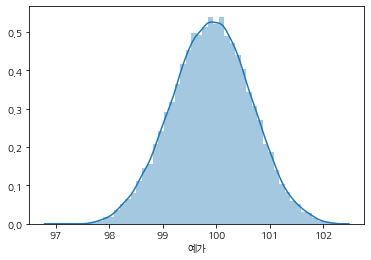

In [13]:
sns.distplot(train['예가'])

In [14]:
train['예가'].describe()

count    31776.000000
mean        99.905418
std          0.732136
min         97.069199
25%         99.406502
50%         99.912399
75%        100.410723
max        102.201698
Name: 예가, dtype: float64

## 2. 가격

In [15]:
train.filter(regex='금액|가격').head()

,기초금액,추정가격,예정가격,투찰금액
0,"166,200,000 원","151,090,909 원","165,215,275 원","145,039,600"
1,"49,000,000 원","44,545,455 원","48,643,800 원","42,786,020"
2,"35,000,000 원","31,818,182 원","34,692,275 원","30,530,000"
3,"27,000,000 원","24,545,455 원","26,967,025 원","23,688,450"
4,"64,460,000 원","58,600,000 원","64,254,925 원","56,382,000"


가격에 대한 **원** 단위를 제거 및 **,**를 제거합니다.

In [16]:
price_cols = train.filter(regex='금액|가격').columns
price_cols

Index(['기초금액', '추정가격', '예정가격', '투찰금액'], dtype='object')

In [17]:
train[price_cols].head()

,기초금액,추정가격,예정가격,투찰금액
0,"166,200,000 원","151,090,909 원","165,215,275 원","145,039,600"
1,"49,000,000 원","44,545,455 원","48,643,800 원","42,786,020"
2,"35,000,000 원","31,818,182 원","34,692,275 원","30,530,000"
3,"27,000,000 원","24,545,455 원","26,967,025 원","23,688,450"
4,"64,460,000 원","58,600,000 원","64,254,925 원","56,382,000"


### ,를 제거합니다.

In [18]:
for col in price_cols:
    train[col] = train[col].str.replace(',', '')
    train[col] = train[col].str.replace('원', '')

In [19]:
train[price_cols].head()

,기초금액,추정가격,예정가격,투찰금액
0,166200000,151090909,165215275,145039600
1,49000000,44545455,48643800,42786020
2,35000000,31818182,34692275,30530000
3,27000000,24545455,26967025,23688450
4,64460000,58600000,64254925,56382000


### NaN값을 채워줍니다.

type을 int로 변경하기 전 NaN 값을 채워줍니다.

In [20]:
train[price_cols].isnull().sum()

기초금액     0
추정가격    66
예정가격     0
투찰금액     0
dtype: int64

In [21]:
train[price_cols] = train[price_cols].fillna(0)

In [22]:
train[price_cols].isnull().sum()

기초금액    0
추정가격    0
예정가격    0
투찰금액    0
dtype: int64

In [23]:
train[price_cols].head()

,기초금액,추정가격,예정가격,투찰금액
0,166200000,151090909,165215275,145039600
1,49000000,44545455,48643800,42786020
2,35000000,31818182,34692275,30530000
3,27000000,24545455,26967025,23688450
4,64460000,58600000,64254925,56382000


In [24]:
train[price_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31776 entries, 0 to 31787
Data columns (total 4 columns):
기초금액    31776 non-null object
추정가격    31776 non-null object
예정가격    31776 non-null object
투찰금액    31776 non-null object
dtypes: object(4)
memory usage: 1.2+ MB


### float 타입으로 가격 컬럼을 변환

In [25]:
train[price_cols] = train[price_cols].astype('float32')

In [26]:
train[price_cols].head()

,기초금액,추정가격,예정가격,투찰금액
0,166200000.0,151090912.0,165215280.0,145039600.0
1,49000000.0,44545456.0,48643800.0,42786020.0
2,35000000.0,31818182.0,34692276.0,30530000.0
3,27000000.0,24545456.0,26967024.0,23688450.0
4,64460000.0,58600000.0,64254924.0,56382000.0


In [27]:
train[price_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31776 entries, 0 to 31787
Data columns (total 4 columns):
기초금액    31776 non-null float32
추정가격    31776 non-null float32
예정가격    31776 non-null float32
투찰금액    31776 non-null float32
dtypes: float32(4)
memory usage: 744.8 KB


### NaN 값을 drop 하였으므로, index 를 초기화한다

In [28]:
train = train.reset_index(drop=True)

### 명시된 예정 가격과 예가 비율 * 기초금액과 가격이 과연 같을까?

In [29]:
train['기초금액'][:5]

0    166200000.0
1     49000000.0
2     35000000.0
3     27000000.0
4     64460000.0
Name: 기초금액, dtype: float32

In [30]:
train['예정가격'][:5]

0    165215280.0
1     48643800.0
2     34692276.0
3     26967024.0
4     64254924.0
Name: 예정가격, dtype: float32

In [31]:
train['예가'][:5]

0    99.407501
1    99.273003
2    99.120697
3    99.877800
4    99.681801
Name: 예가, dtype: float32

**기초금액** x **예가** = **예정가격** 정말 일치할까? (왜냐하면, 소수 4째짜리까지만 반영되기 때문에 다를 수 있다)

10개만 테스트해 보겠다.

In [32]:
for i in range(10):
    calculated_price = train['기초금액'][i] * train['예가'][i] / 100
    printed_price = train['예정가격'][i]
    diff = abs(calculated_price - printed_price)
    print('명시된 가격과 계산된 금액의 차이: {:.2f} 원'.format(diff))

명시된 가격과 계산된 금액의 차이: 17.28 원
명시된 가격과 계산된 금액의 차이: 26.56 원
명시된 가격과 계산된 금액의 차이: 31.52 원
명시된 가격과 계산된 금액의 차이: 17.28 원
명시된 가격과 계산된 금액의 차이: 35.04 원
명시된 가격과 계산된 금액의 차이: 46.72 원
명시된 가격과 계산된 금액의 차이: 157.44 원
명시된 가격과 계산된 금액의 차이: 123.52 원
명시된 가격과 계산된 금액의 차이: 18.72 원
명시된 가격과 계산된 금액의 차이: 143.36 원


### 전체 평균 차이 계산

In [33]:
total_size = len(train)
diff = 0
for i in range(total_size):
    calculated_price = train['기초금액'][i] * train['예가'][i] / 100
    printed_price = train['예정가격'][i]
    diff += abs(calculated_price - printed_price)
diff /= total_size
print('평균 오차 가격: {:.2f} 원'.format(diff))

평균 오차 가격: 358.07 원


### 금액&가격 컬럼간 corr() 확인

column들이 매우 높은 상관관계를 가지고 있다. 

따라서, 이중 **하나의 컬럼만 지정해서 활용**하면 될 것으로 보입니다.

가장 base가 되는 **기초금액** 컬럼을 활용하겠습니다.

In [34]:
train[price_cols].corr()

,기초금액,추정가격,예정가격,투찰금액
기초금액,1.000000,0.998769,0.999979,0.998075
추정가격,0.998769,1.000000,0.998765,0.996852
예정가격,0.999979,0.998765,1.000000,0.998081
투찰금액,0.998075,0.996852,0.998081,1.000000


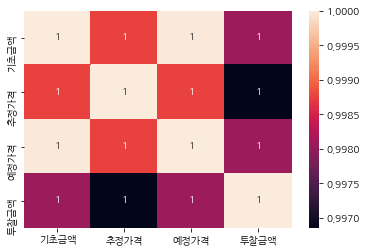

In [35]:
sns.heatmap(train[price_cols].corr(), annot=True)

## 3. 날짜

In [36]:
train['입찰일시'].head()

0    2020-03-13 16:00
1    2020-03-13 16:00
2    2020-03-13 16:00
3    2020-03-13 16:00
4    2020-03-13 16:00
Name: 입찰일시, dtype: object

NaN 값 확인

In [37]:
train['입찰일시'].isnull().sum()

0

### 날짜를 변환 (datetime)

In [38]:
train['입찰일시'] = pd.to_datetime(train['입찰일시'])

In [39]:
train['year'] = train['입찰일시'].dt.year
train['month'] = train['입찰일시'].dt.month
train['day'] = train['입찰일시'].dt.day
train['hour'] = train['입찰일시'].dt.hour
train['minute'] = train['입찰일시'].dt.minute
train['dayofweek'] = train['입찰일시'].dt.dayofweek
train['weekofyear'] = train['입찰일시'].dt.weekofyear
train['dayofyear'] = train['입찰일시'].dt.dayofyear
train['quarter'] = train['입찰일시'].dt.quarter

### 연도 확인

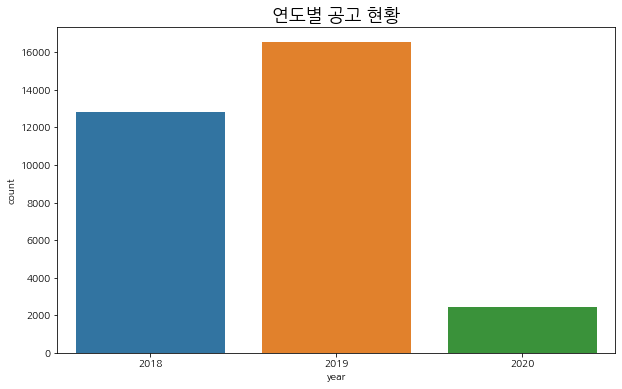

In [106]:
plt.figure(figsize=(10, 6))
sns.countplot(train['year'])
plt.title('연도별 공고 현황', fontsize=18)
plt.show()

### 분기별 공고 현황

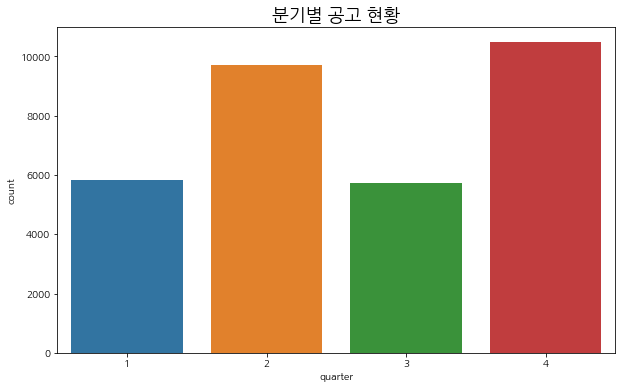

In [105]:
plt.figure(figsize=(10, 6))
sns.countplot(train['quarter'])
plt.title('분기별 공고 현황', fontsize=18)
plt.show()

### 월별 공고 현황

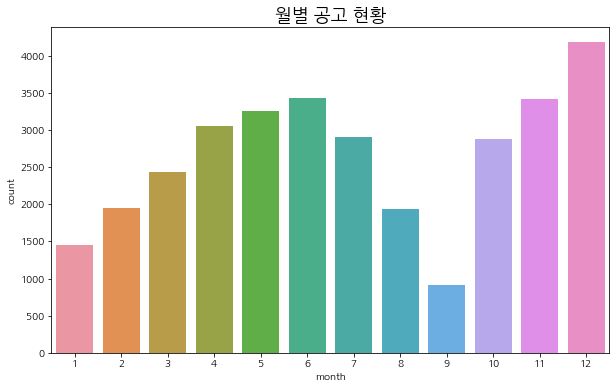

In [104]:
plt.figure(figsize=(10, 6))
sns.countplot(train['month'])
plt.title('월별 공고 현황', fontsize=18)
plt.show()

### 일별 공고 현황

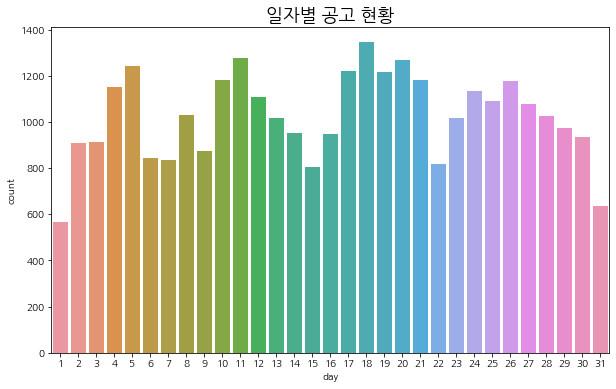

In [103]:
plt.figure(figsize=(10, 6))
sns.countplot(train['day'])
plt.title('일자별 공고 현황', fontsize=18)
plt.show()

### 시간대별 공고 현황

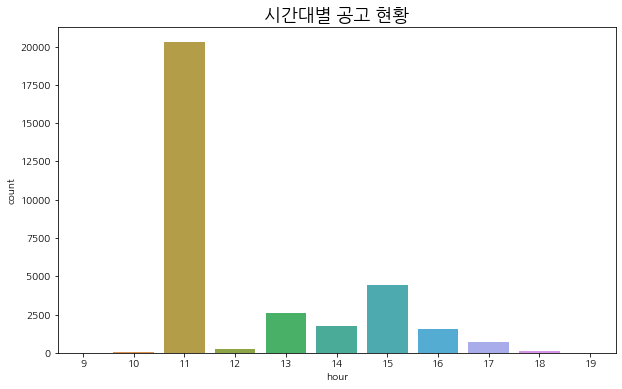

In [102]:
plt.figure(figsize=(10, 6))
sns.countplot(train['hour'])
plt.title('시간대별 공고 현황', fontsize=18)
plt.show()

### 분(minute)별 공고 현황

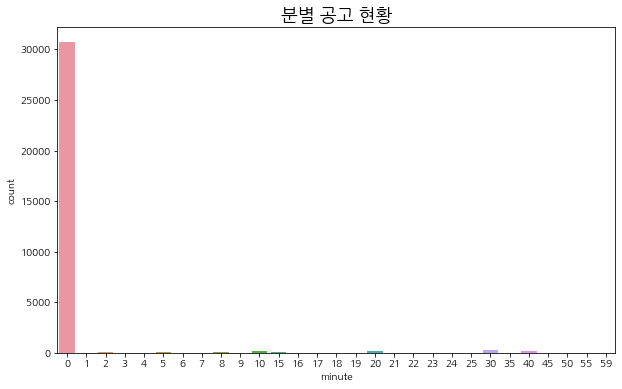

In [101]:
plt.figure(figsize=(10, 6))
sns.countplot(train['minute'])
plt.title('분별 공고 현황', fontsize=18)
plt.show()

### 요일별 공고 현황

- 0: 월요일 ~ 6: 일요일
- 일요일은 역시 공고가 없다.
- 토요일은 공고가 2건 있었다.

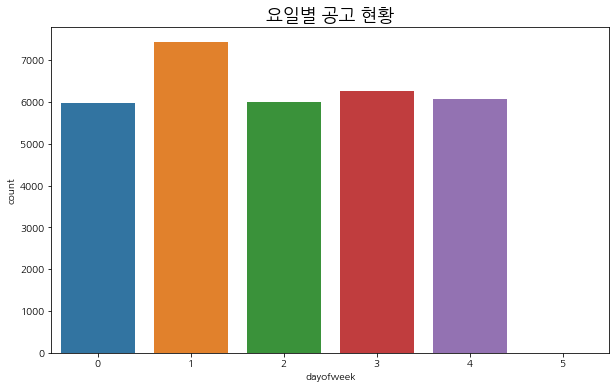

In [100]:
plt.figure(figsize=(10, 6))
sns.countplot(train['dayofweek'])
plt.title('요일별 공고 현황', fontsize=18)
plt.show()

## 4. 지역

In [47]:
train['지역'].value_counts()

전남                4141
경북                3884
경기                3756
경남                3480
강원                3259
전북                2544
충남                2204
충북                1631
서울                1608
부산                 821
제주                 813
대구                 729
인천                 722
대전                 425
광주                 344
울산                 338
전국                 240
세종                 138
전국,경기              128
전국,경북               58
전국,서울               57
전국,전남               44
전국,전북               38
전국,경남               37
서울,경기               36
전국,충남               31
전국,충북               28
전국,강원               27
전국,부산               23
전국,인천               23
                  ... 
전국,세종               12
충남,세종                9
전국,대전                8
전국,제주                8
부산,경남                7
인천,경기                5
서울,인천,경기             5
전북,전남                3
충남,전북                3
대전,충북,충남,세종          3
대전,충북,세종             2
대전,충남                2
대전,충북,충남   

### 지역을 , 기준으로 분리합니다.

In [48]:
area = train['지역'].str.split(',')

In [49]:
area.head()

0    [경기]
1    [충남]
2    [충남]
3    [강원]
4    [전북]
Name: 지역, dtype: object

### 최소 값과, 최대 값을 살펴봅니다.

In [50]:
area_count = area.apply(lambda x: len(x))
area_count.min(), area_count.max()

(1, 5)

### 각각의 데이터를 분리하여 column을 만들도록 합니다.

In [51]:
area_split = train["지역"].str.split(",", n=5, expand=True) 

In [52]:
area_split.iloc[[345, 12390, 1646, 16326]]

,0,1,2,3,4
345,전국,None,None,None,None
12390,대전,충남,None,None,None
1646,전국,울산,경남,None,None
16326,부산,대구,울산,경북,경남


In [53]:
area_key = list(train['지역'].value_counts()[:18].keys())
area_key

['전남',
 '경북',
 '경기',
 '경남',
 '강원',
 '전북',
 '충남',
 '충북',
 '서울',
 '부산',
 '제주',
 '대구',
 '인천',
 '대전',
 '광주',
 '울산',
 '전국',
 '세종']

In [54]:
data = np.zeros(shape=(len(area), 18))
data.shape

(31776, 18)

In [55]:
area_df = pd.DataFrame(columns=area_key, data=data)

### 지역과 지역 값 컬럼을 합칩니다

In [56]:
area_merged = pd.concat([area, area_df], axis=1)

In [57]:
area_merged.tail()

,지역,전남,경북,경기,경남,강원,전북,충남,충북,서울,부산,제주,대구,인천,대전,광주,울산,전국,세종
31771,[경남],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31772,[전국],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31773,[전국],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31774,[충북],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31775,[경남],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### list에 지역이 포함된 경우 1로 체크합니다

In [58]:
def check_area(data):
    for d in data['지역']:
        data[d] = 1
    return data

In [59]:
area = area_merged.apply(check_area, axis=1)

In [60]:
area.head()

,지역,전남,경북,경기,경남,강원,전북,충남,충북,서울,부산,제주,대구,인천,대전,광주,울산,전국,세종
0,[경기],0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,[충남],0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,[충남],0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,[강원],0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,[전북],0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
area.iloc[1646]

지역    [전국, 울산, 경남]
전남               0
경북               0
경기               0
경남               1
강원               0
전북               0
충남               0
충북               0
서울               0
부산               0
제주               0
대구               0
인천               0
대전               0
광주               0
울산               1
전국               1
세종               0
Name: 1646, dtype: object

### 지역은 drop합니다

In [62]:
area = area.drop('지역', 1)

In [63]:
area.head()

,전남,경북,경기,경남,강원,전북,충남,충북,서울,부산,제주,대구,인천,대전,광주,울산,전국,세종
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
area.shape

(31776, 18)

In [65]:
train.shape

(31776, 76)

## 5. 업체별 사정율

사정율이란 개찰후 결정된 예정가격과 예비가격기초금액같의 차이를 백분율로 나타낸것이라고 정의 할 수 있습니다.

법률적인 개념은 아니지만 입찰담당자들 사이에 널리 쓰이는 개념입니다.

예를 들어

기초금액 : 100억

예정가격 : 101억이라면

사정율을 1%라고 합니다.

즉, 표면적으로 보이는 투찰율은 다르지만 사정율을 계산해서 보면 패턴을 볼 수 있다는 것이지요.

특정발주처나 특정업체의 입찰 패턴을 분석할 때 투찰율을 분석하면 아무런 결과를 얻을 수가 없습니다.

그러나 **사정율로 분석을 하게 되면 패턴을 발견**할 수도 있습니다.

복수예비가격을 사전에 발표하는 발주처의 성향을 분석할때도 금액만으로는 원하는 결과를 얻을수 없습니다.

각각의 **예비가격에 대한 사정율을 계산해서 일정기간 분석해 보면 패턴이 있음**을 알 수 있습니다.

In [66]:
train['업체별사정율'].head()

0    99.4565
1    99.5138
2    99.4114
3    99.9886
4    99.6845
Name: 업체별사정율, dtype: object

In [67]:
train.loc[train['업체별사정율'].str.contains('-'), '업체별사정율'].head(10)

288      ( - )
345      ( - )
854      ( - )
1046     ( - )
2227     ( - )
2292     ( - )
2764     ( - )
2765     ( - )
2798     ( - )
3056     ( - )
Name: 업체별사정율, dtype: object

### ( - ) 이루어진 데이터는 0으로 치환합니다

In [68]:
train.loc[train['업체별사정율'].str.contains('-'), '업체별사정율'] = np.nan

In [69]:
train['업체별사정율'] = train['업체별사정율'].fillna(0)

### 업체별 사정율의 데이터를 float로 변경합니다

In [70]:
train['업체별사정율'] = train['업체별사정율'].astype('float32')

## 7. 불필요한 컬럼 정리

In [71]:
train.columns

Index(['번호', '공고업종', '지역', '공고번호', '발주기관', '입찰일시', '기초금액', '추정가격', '낙찰하한율',
       '예정가격', '예가', '낙찰하한가', '투찰', '업체명', '대표자', '투찰금액', '투찰율', '기초대비',
       '업체별사정율', 'num_1_num', 'num_1_money', 'num_1_per', 'num_2_num',
       'num_2_money', 'num_2_per', 'num_3_num', 'num_3_money', 'num_3_per',
       'num_4_num', 'num_4_money', 'num_4_per', 'num_5_num', 'num_5_money',
       'num_5_per', 'num_6_num', 'num_6_money', 'num_6_per', 'num_7_num',
       'num_7_money', 'num_7_per', 'num_8_num', 'num_8_money', 'num_8_per',
       'num_9_num', 'num_9_money', 'num_9_per', 'num_10_num', 'num_10_money',
       'num_10_per', 'num_11_num', 'num_11_money', 'num_11_per', 'num_12_num',
       'num_12_money', 'num_12_per', 'num_13_num', 'num_13_money',
       'num_13_per', 'num_14_num', 'num_14_money', 'num_14_per', 'num_15_num',
       'num_15_money', 'num_15_per', 'total', 'Unnamed: 65', 'Unnamed: 66',
       'year', 'month', 'day', 'hour', 'minute', 'dayofweek', 'weekofyear',
       'dayofyear', 'qu

In [72]:
cols = ['업체명', 
        '기초금액', 
        '예가', 
        '업체별사정율',
        'year', 
        'month', 
        'day', 
        'hour', 
        'minute', 
        'dayofweek', 
        'weekofyear', 
        'dayofyear', 
        'quarter', 
       ]

In [73]:
train[cols].head()

,업체명,기초금액,예가,업체별사정율,year,month,day,hour,minute,dayofweek,weekofyear,dayofyear,quarter
0,제이티건설(주),166200000.0,99.407501,99.456497,2020,3,13,16,0,4,11,73,1
1,통일종합건설 주식회사,49000000.0,99.273003,99.513802,2020,3,13,16,0,4,11,73,1
2,성문건설 주식회사,35000000.0,99.120697,99.411400,2020,3,13,16,0,4,11,73,1
3,(주)덕산종합건설,27000000.0,99.877800,99.988602,2020,3,13,16,0,4,11,73,1
4,(유)아라야,64460000.0,99.681801,99.684502,2020,3,13,16,0,4,11,73,1


In [74]:
train[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31776 entries, 0 to 31775
Data columns (total 13 columns):
업체명           31776 non-null object
기초금액          31776 non-null float32
예가            31776 non-null float32
업체별사정율        31776 non-null float32
year          31776 non-null int64
month         31776 non-null int64
day           31776 non-null int64
hour          31776 non-null int64
minute        31776 non-null int64
dayofweek     31776 non-null int64
weekofyear    31776 non-null int64
dayofyear     31776 non-null int64
quarter       31776 non-null int64
dtypes: float32(3), int64(9), object(1)
memory usage: 2.8+ MB


### df에 정리된 train 데이터와 area 데이터를 합칩니다

In [75]:
df = pd.concat([train[cols], area], axis=1)

In [76]:
df.head()

,업체명,기초금액,예가,업체별사정율,year,month,day,hour,minute,dayofweek,...,서울,부산,제주,대구,인천,대전,광주,울산,전국,세종
0,제이티건설(주),166200000.0,99.407501,99.456497,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,통일종합건설 주식회사,49000000.0,99.273003,99.513802,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,성문건설 주식회사,35000000.0,99.120697,99.411400,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(주)덕산종합건설,27000000.0,99.877800,99.988602,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,(유)아라야,64460000.0,99.681801,99.684502,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 지역도 잘 합쳐져 있는지 확인합니다

In [77]:
df.iloc[:, 13:].tail()

,전남,경북,경기,경남,강원,전북,충남,충북,서울,부산,제주,대구,인천,대전,광주,울산,전국,세종
31771,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31775,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
train['지역'].tail()

31771    경남
31772    전국
31773    전국
31774    충북
31775    경남
Name: 지역, dtype: object

### 업체별사정율 -> 사정율 (컬럼명 변환)

In [79]:
df = df.rename(columns={'업체별사정율': '사정율'})

In [80]:
df.head()

,업체명,기초금액,예가,사정율,year,month,day,hour,minute,dayofweek,...,서울,부산,제주,대구,인천,대전,광주,울산,전국,세종
0,제이티건설(주),166200000.0,99.407501,99.456497,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,통일종합건설 주식회사,49000000.0,99.273003,99.513802,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,성문건설 주식회사,35000000.0,99.120697,99.411400,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(주)덕산종합건설,27000000.0,99.877800,99.988602,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,(유)아라야,64460000.0,99.681801,99.684502,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 8. 사정율 - 예가 컬럼 생성 (1등 업체의 근접도 확인)

In [81]:
df['근접율'] = abs(df['예가'] - df['사정율'])

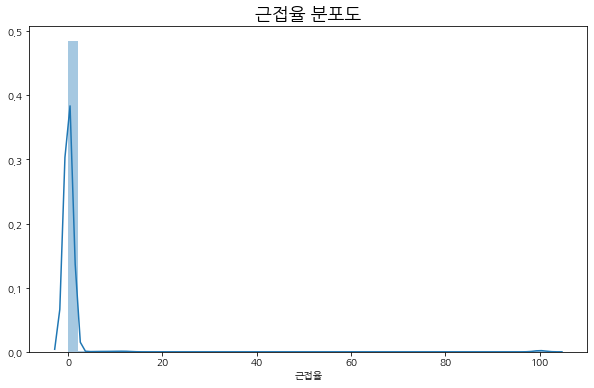

In [99]:
plt.figure(figsize=(10, 6))
sns.distplot(df['근접율'])
plt.title('근접율 분포도', fontsize=18)
plt.show()

In [83]:
df.loc[df['근접율'] > 30, '근접율'].head(20)

288     100.150597
345      99.907997
854      99.307800
1046    100.894501
2227     99.351601
2292    100.069702
2764     98.986198
2765    100.400200
2798    100.603203
3056     99.776497
3298    100.022202
3972    100.263702
4044    100.124496
4242     99.884697
4591    100.806999
5824    100.657700
5826    100.247002
6035     99.893700
6185    100.836197
6189    100.503700
Name: 근접율, dtype: float32

사정율이 나와 있지 않은 column은 우리가 0으로 채워 주었기 때문에 100 이상의 수치가 나온다. 

해당 컬럼은 제외하고 다시 시각화

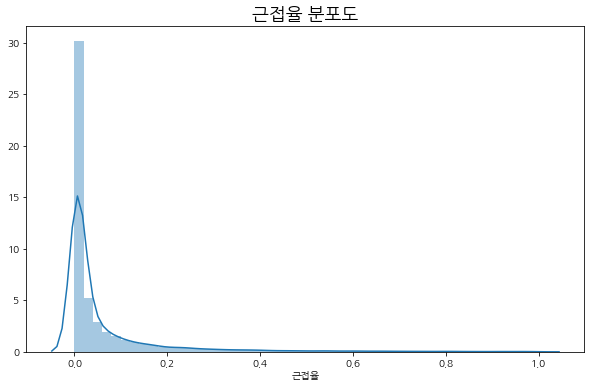

In [98]:
plt.figure(figsize=(10, 6))
sns.distplot(df.loc[df['근접율'] < 1, '근접율'])
plt.title('근접율 분포도', fontsize=18)
plt.show()

선정된 대다수의 업체가 **근접율을 0.0 ~ 0.2 이하**로 가져가고 있다는 점을 볼 수 있다

## 8. 상위 업체 사정율 분석

주로 활용할 유의미한 feature 정의
- 예가 (예측 label)
- 일자 (datetime) 관련 column

안타깝께도... 기타 활용할만한 지표는 크게 보이지 않는다.

### 잘 되는 업체의 사정율 확인

In [85]:
df['업체명'].value_counts().head(50)

태양종합건설 주식회사      28
신우건설 주식회사        28
남광건설 주식회사        27
신영종합건설(주)        25
주식회사 우리종합건설      25
일진건설 주식회사        25
동우건설 주식회사        24
삼진건설(주)          24
주식회사 혜성종합건설      23
보광종합건설 주식회사      23
우일종합건설(주)        22
효창건설(주)          22
청암종합건설 주식회사      22
영진건설(주)          22
대연종합건설 주식회사      22
거성종합건설(주)        21
세움종합건설 주식회사      21
세원종합건설 주식회사      21
우진종합건설(주)        20
두마종합건설주식회사       20
주식회사 부림종합건설      20
주식회사 덕성건설        20
우림종합건설(주)        20
서림종합건설 주식회사      20
유창건설 주식회사        20
(주)동일종합건설        20
대림종합건설 주식회사      20
예림종합건설(주)        20
청진건설주식회사         20
주식회사 태화건설        19
대창건설(주)          19
성원건설(주)          19
승원종합건설(주)        19
제이와이건설 주식회사      19
금종종합건설 주식회사      19
(주)거성종합건설        19
주식회사 에스엠건설       19
성인종합건설 주식회사      19
대호종합건설(주)        19
대원건설(주)          18
주식회사 다우종합건설      18
주식회사 일성건설        18
대영건설 주식회사        18
대일종합건설 주식회사      18
제이티건설(주)         18
(주)삼구건설          18
태창건설합자회사         18
주식회사 조영건설        18
제이케이종합건설 주식회사    18
주식회사 백율          17


### 시각화 함수화

In [139]:
def visualize_pct_time(data):
    plt.figure(figsize=(10, 6))
    d = data.groupby('year')['사정율'].mean()
    sns.barplot(x=d.index, y=d)
    plt.ylim(d.min() - 0.02, d.max() + 0.02)
    plt.title('평균 사정율 (연도별)', fontsize=18)
    plt.show()
    print(d)
    print('===='*10)
    
    plt.figure(figsize=(10, 6))
    d = data.groupby('quarter')['사정율'].mean()
    sns.barplot(x=d.index, y=d)
    plt.ylim(d.min() - 0.02, d.max() + 0.02)
    plt.title('평균 사정율 (분기별)', fontsize=18)
    plt.show()
    print(d)
    print('===='*10)
    
    plt.figure(figsize=(10, 6))
    d = data.groupby('month')['사정율'].mean()
    sns.barplot(x=d.index, y=d)
    plt.ylim(d.min() - 0.02, d.max() + 0.02)
    plt.title('평균 사정율 (월별)', fontsize=18)
    plt.show()
    print(d)
    print('===='*10)
    
    plt.figure(figsize=(10, 6))
    d = data.groupby('day')['사정율'].mean()
    sns.barplot(x=d.index, y=d)
    plt.ylim(d.min() - 0.02, d.max() + 0.02)
    plt.title('평균 사정율 (일자별)', fontsize=18)
    plt.show()
    print(d)
    print('===='*10)
    
    plt.figure(figsize=(10, 6))
    d = data.groupby('dayofweek')['사정율'].mean()
    sns.barplot(x=d.index, y=d)
    plt.ylim(d.min() - 0.02, d.max() + 0.02)
    plt.title('평균 사정율 (요일별)', fontsize=18)
    plt.show()
    print(d)
    print('===='*10)
    
    plt.figure(figsize=(10, 6))
    d = data.groupby('hour')['사정율'].mean()
    sns.barplot(x=d.index, y=d)
    plt.ylim(d.min() - 0.02, d.max() + 0.02)
    plt.title('평균 사정율 (시간별)', fontsize=18)
    plt.show()
    print(d)
    print('===='*10)
    
    plt.figure(figsize=(10, 6))
    d = data.groupby('minute')['사정율'].mean()
    sns.barplot(x=d.index, y=d)
    plt.ylim(d.min() - 0.02, d.max() + 0.02)
    plt.title('평균 사정율 (분별)', fontsize=18)
    plt.show()
    print(d)
    print('===='*10)
    
    plt.figure(figsize=(10, 6))
    d = data.groupby('weekofyear')['사정율'].mean()
    sns.barplot(x=d.index, y=d)
    plt.ylim(d.min() - 0.02, d.max() + 0.02)
    plt.title('평균 사정율 (주차별)', fontsize=18)
    plt.show()
    print(d)
    print('===='*10)

In [140]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### top 50개 업체 분석

In [144]:
df['업체명'].value_counts().head(50)

태양종합건설 주식회사      28
신우건설 주식회사        28
남광건설 주식회사        27
신영종합건설(주)        25
주식회사 우리종합건설      25
일진건설 주식회사        25
동우건설 주식회사        24
삼진건설(주)          24
주식회사 혜성종합건설      23
보광종합건설 주식회사      23
우일종합건설(주)        22
효창건설(주)          22
청암종합건설 주식회사      22
영진건설(주)          22
대연종합건설 주식회사      22
거성종합건설(주)        21
세움종합건설 주식회사      21
세원종합건설 주식회사      21
우진종합건설(주)        20
두마종합건설주식회사       20
주식회사 부림종합건설      20
주식회사 덕성건설        20
우림종합건설(주)        20
서림종합건설 주식회사      20
유창건설 주식회사        20
(주)동일종합건설        20
대림종합건설 주식회사      20
예림종합건설(주)        20
청진건설주식회사         20
주식회사 태화건설        19
대창건설(주)          19
성원건설(주)          19
승원종합건설(주)        19
제이와이건설 주식회사      19
금종종합건설 주식회사      19
(주)거성종합건설        19
주식회사 에스엠건설       19
성인종합건설 주식회사      19
대호종합건설(주)        19
대원건설(주)          18
주식회사 다우종합건설      18
주식회사 일성건설        18
대영건설 주식회사        18
대일종합건설 주식회사      18
제이티건설(주)         18
(주)삼구건설          18
태창건설합자회사         18
주식회사 조영건설        18
제이케이종합건설 주식회사    18
주식회사 백율          17


In [148]:
company = list(df['업체명'].value_counts().head(50).keys())
company[:5]

['태양종합건설 주식회사', '신우건설 주식회사', '남광건설 주식회사', '신영종합건설(주)', '주식회사 우리종합건설']

In [150]:
df.loc[df['업체명'].isin(company)].head()

,업체명,기초금액,예가,사정율,year,month,day,hour,minute,dayofweek,...,부산,제주,대구,인천,대전,광주,울산,전국,세종,근접율
0,제이티건설(주),166200000.0,99.407501,99.456497,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048996
7,(주)동일종합건설,131254000.0,100.563698,100.712997,2020,3,13,15,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149300
19,대림종합건설 주식회사,152384992.0,100.215202,100.254097,2020,3,13,11,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038895
20,(주)동일종합건설,140848000.0,99.618202,99.675301,2020,3,12,17,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057098
48,우림종합건설(주),99250000.0,99.945999,99.966797,2020,3,11,14,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020798


In [151]:
df.loc[df['업체명'].isin(company)].shape

(1032, 32)

### 상위 50개 업체에 대한 사정율 분석

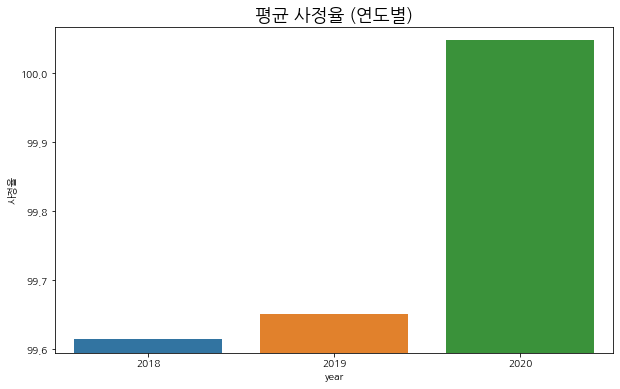

year
2018     99.614723
2019     99.650284
2020    100.047600
Name: 사정율, dtype: float32


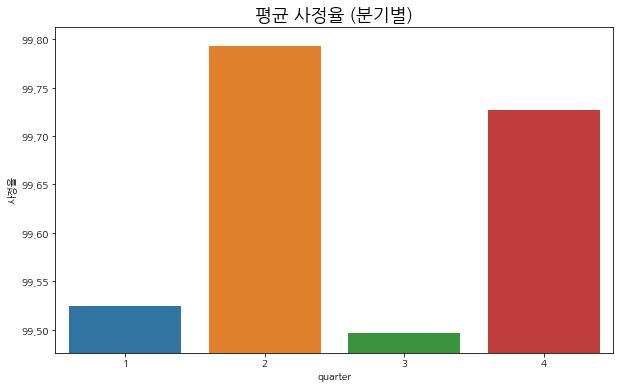

quarter
1    99.524040
2    99.793167
3    99.495934
4    99.726967
Name: 사정율, dtype: float32


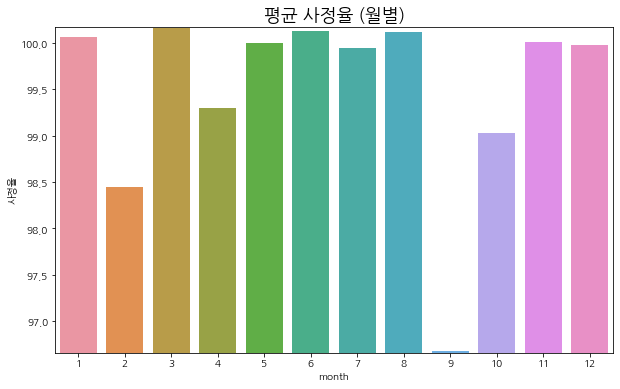

month
1     100.058823
2      98.448105
3     100.153893
4      99.295822
5      99.994537
6     100.129677
7      99.948189
8     100.118813
9      96.680954
10     99.025192
11    100.005043
12     99.979912
Name: 사정율, dtype: float32


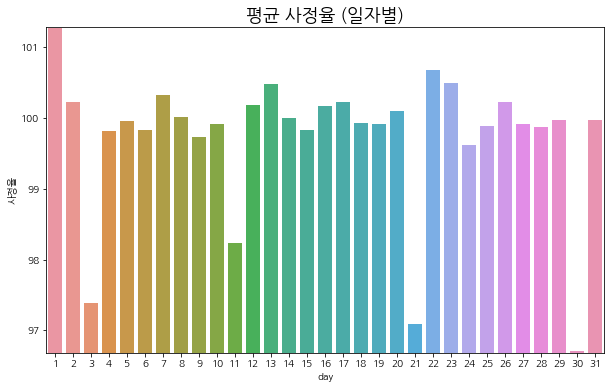

day
1     101.271019
2     100.231270
3      97.381348
4      99.821388
5      99.954758
6      99.833641
7     100.318314
8     100.020660
9      99.737701
10     99.918396
11     98.235985
12    100.185211
13    100.478363
14     99.994896
15     99.834633
16    100.165291
17    100.220901
18     99.927635
19     99.911423
20    100.103706
21     97.082840
22    100.683266
23    100.495117
24     99.625702
25     99.886864
26    100.223473
27     99.914177
28     99.872894
29     99.967613
30     96.702568
31     99.965637
Name: 사정율, dtype: float32


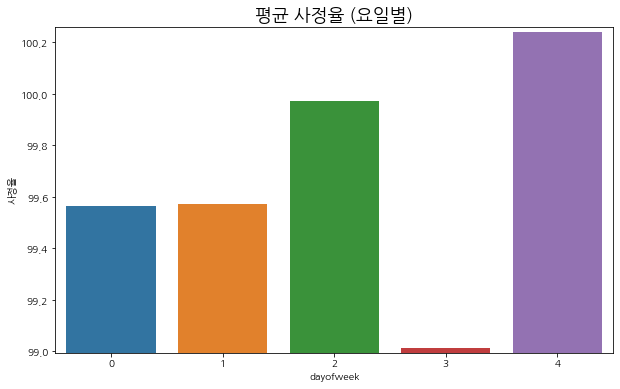

dayofweek
0     99.562622
1     99.574066
2     99.974068
3     99.014107
4    100.241432
Name: 사정율, dtype: float32


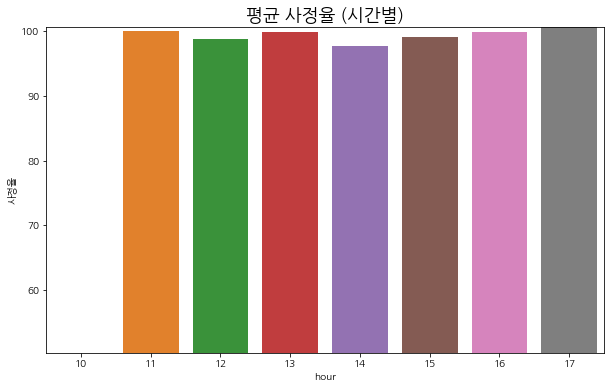

hour
10     50.258099
11    100.028793
12     98.877197
13     99.950279
14     97.659386
15     99.175568
16     99.841110
17    100.710976
Name: 사정율, dtype: float32


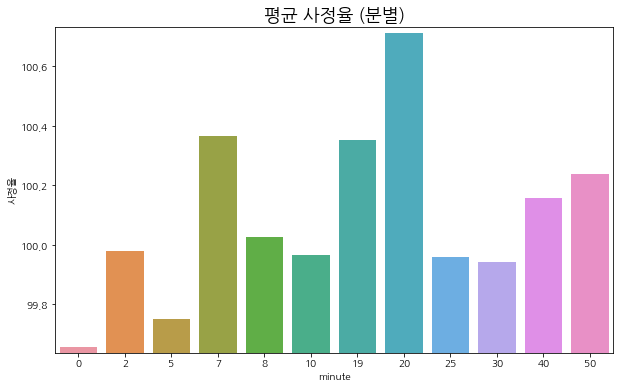

minute
0      99.656639
2      99.977829
5      99.748566
7     100.364998
8     100.026352
10     99.964233
19    100.351303
20    100.712151
25     99.957802
30     99.941765
40    100.157654
50    100.236298
Name: 사정율, dtype: float32


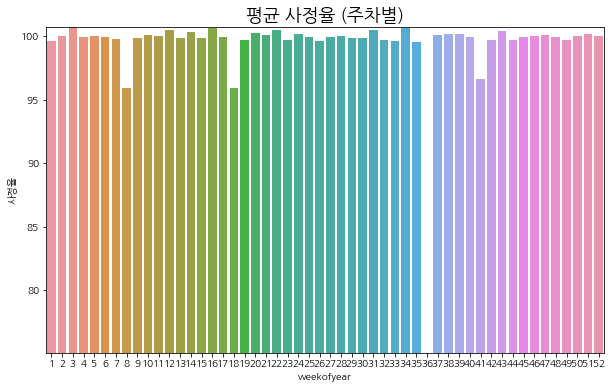

weekofyear
1      99.661919
2     100.014099
3     100.747063
4      99.940147
5     100.009071
6      99.955833
7      99.823471
8      95.927040
9      99.859200
10    100.142670
11    100.001343
12    100.518356
13     99.893852
14    100.370247
15     99.850792
16    100.627945
17     99.982849
18     95.889160
19     99.727051
20    100.228340
21    100.135078
22    100.518684
23     99.685753
24    100.148605
25     99.961456
26     99.614449
27     99.932823
28    100.017334
29     99.884766
30     99.870316
31    100.464653
32     99.721504
33     99.657547
34    100.685196
35     99.553894
36     75.060875
37    100.103607
38    100.163940
39    100.151520
40     99.986008
41     96.657692
42     99.729042
43    100.439697
44     99.698433
45     99.980774
46    100.067871
47    100.138771
48     99.932625
49     99.713791
50     99.992912
51    100.159637
52    100.053780
Name: 사정율, dtype: float32


In [152]:
visualize_pct_time(df.loc[df['업체명'].isin(company)])

In [153]:
df.head()

,업체명,기초금액,예가,사정율,year,month,day,hour,minute,dayofweek,...,부산,제주,대구,인천,대전,광주,울산,전국,세종,근접율
0,제이티건설(주),166200000.0,99.407501,99.456497,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048996
1,통일종합건설 주식회사,49000000.0,99.273003,99.513802,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240799
2,성문건설 주식회사,35000000.0,99.120697,99.411400,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290703
3,(주)덕산종합건설,27000000.0,99.877800,99.988602,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110802
4,(유)아라야,64460000.0,99.681801,99.684502,2020,3,13,16,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002701


## 9. 예측

* 사정율이 중요한 feature라 판단
* 따라서, 사정율이 0인 컬럼은 제외합니다

In [205]:
train_data = df.loc[df['사정율'] > 85]

In [206]:
train_data.shape

(31595, 32)

### 업체명은 drop 합니다

In [207]:
train_data = train_data.drop('업체명', 1)

### 지역은 서울, 전국을 포함하는 지표만 추립니다

In [208]:
train_data = train_data.loc[(train_data['서울'] == 1) | (train_data['전국'] == 1)]

In [209]:
area_drop_cols = ['전남', '경북', '경기', '경남', '강원', '전북', '충남', '충북', '부산', '제주', '대구',
       '인천', '대전', '광주', '울산', '세종']

In [210]:
train_data = train_data.drop(area_drop_cols, axis=1)

### 예가, 사정율, 근접율은 사후에 나오는 지표 이므로 drop 합니다

In [211]:
train_feature = train_data.drop(['예가', '사정율', '근접율'], 1)
train_label = train_data['예가']

### 최종 Feature

In [253]:
train_feature.head()

,기초금액,year,month,day,hour,minute,dayofweek,weekofyear,dayofyear,quarter,서울,전국
167,4.674210e+08,2020,3,6,15,0,4,10,66,1,1.0,0.0
219,1.154583e+09,2020,3,6,11,0,4,10,66,1,1.0,0.0
235,6.420660e+08,2020,3,5,15,0,3,10,65,1,1.0,0.0
275,1.330120e+09,2020,3,5,11,0,3,10,65,1,1.0,0.0
305,9.960500e+08,2020,3,4,15,0,2,10,64,1,1.0,0.0


### 모델링

In [222]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [170]:
SEED = 123

In [220]:
# 코드 비공개 처리

[0]	validation_0-mae:97.43237	validation_1-mae:97.48483
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 30 rounds.
[200]	validation_0-mae:1.72026	validation_1-mae:1.77291
[400]	validation_0-mae:0.53526	validation_1-mae:0.61973
Stopping. Best iteration:
[390]	validation_0-mae:0.53786	validation_1-mae:0.61945

[0]	validation_0-mae:97.45020	validation_1-mae:97.41235
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 30 rounds.
[200]	validation_0-mae:1.72187	validation_1-mae:1.68547
Stopping. Best iteration:
[349]	validation_0-mae:0.55724	validation_1-mae:0.57244

[0]	validation_0-mae:97.43646	validation_1-mae:97.46812
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 30 rounds.
[200]	validation_0-mae:1.72

In [221]:
pd.DataFrame(list(zip(train_feature.columns, xgb_model.feature_importances_))).sort_values(by=1, ascending=False)

,0,1
9,quarter,0.212947
0,기초금액,0.090076
8,dayofyear,0.089709
11,전국,0.078249
7,weekofyear,0.075134
5,minute,0.074531
6,dayofweek,0.070992
3,day,0.070871
10,서울,0.069562
4,hour,0.059260


In [ ]:
def train_xgb(train_features, train_labels, test_features, num_split=3):
    # 코드 비공개 처리
    return preds

In [298]:
def train_lgbm(train_feature, train_label, test_feature, num_split=5):
    # 코드 비공개 처리
    return preds

In [318]:
def train_xgb(train_feature, train_label, test_feature, num_split=3):
    # 코드 비공개 처리
    return preds

In [334]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, random_state=321)
x_train.shape, x_valid.shape

((1790, 12), (597, 12))

In [335]:
lgbm_pred = train_lgbm(x_train, y_train, x_valid)
xgb_pred = train_xgb(x_train, y_train, x_valid)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	training's l1: 0.596837	training's l2: 0.544079	valid_1's l1: 0.599506	valid_1's l2: 0.56646
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	training's l1: 0.608888	training's l2: 0.56613	valid_1's l1: 0.541242	valid_1's l2: 0.460266
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	training's l1: 0.590583	training's l2: 0.540623	valid_1's l1: 0.624393	valid_1's l2: 0.580429
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	training's l1: 0.593366	training's l2: 0.541869	valid_1's l1: 0.613335	valid_1's l2: 0.57537
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	training's l1: 0.58905	training's l2: 0.536167	valid_1's l1: 0.609964	valid_1's l2: 0.563332
avg score: 0.5976880338001499
[0]

In [336]:
pred = lgbm_pred * 0.6 + xgb_pred * 0.4

In [337]:
abs(pred - y_valid).mean()

0.5554264117899838

## 검증 (시뮬레이션)

In [338]:
validation_df = df.iloc[y_valid.index][['예가', '사정율']].copy()

In [339]:
validation_df.head()

,예가,사정율
14548,98.969002,98.977898
5612,99.151497,99.167297
16649,100.463997,100.474098
26280,99.882004,99.883202
17308,99.960197,99.964798


In [340]:
df.iloc[y_valid.index]['사정율'].head()

14548     98.977898
5612      99.167297
16649    100.474098
26280     99.883202
17308     99.964798
Name: 사정율, dtype: float32

In [341]:
validation_df['pred'] = pred

In [342]:
validation_df.head()

,예가,사정율,pred
14548,98.969002,98.977898,99.907663
5612,99.151497,99.167297,99.847656
16649,100.463997,100.474098,99.921612
26280,99.882004,99.883202,99.940660
17308,99.960197,99.964798,99.905172


### 괴리율 = 예측값 - 예가 (0보다 작으면 무조건 탈락)

In [343]:
validation_df['괴리율'] = validation_df['pred'] - validation_df['예가']

In [344]:
validation_df['선정여부'] = (validation_df['pred'] < validation_df['사정율']) & (validation_df['pred'] > validation_df['예가'])

In [345]:
validation_df.loc[validation_df['괴리율'] >= 0].sort_values(by='괴리율').head()

,예가,사정율,pred,괴리율,선정여부
7468,99.897202,99.933403,99.897466,0.000264,True
6025,99.857002,99.860001,99.857646,0.000643,True
21792,99.869003,99.874496,99.873144,0.004141,True
17479,99.917999,99.919998,99.924551,0.006552,False
26677,99.924004,99.925003,99.938099,0.014095,False


### 선정된 지표 확인

In [346]:
validation_df.loc[validation_df['선정여부'] ==True]

,예가,사정율,pred,괴리율,선정여부
22744,99.438499,100.062599,99.869264,0.430764,True
10751,97.873703,100.247398,99.918239,2.044536,True
26726,99.441704,101.254898,99.859676,0.417972,True
6025,99.857002,99.860001,99.857646,0.000643,True
23983,99.671700,105.500000,99.884492,0.212792,True
21792,99.869003,99.874496,99.873144,0.004141,True
30818,99.890999,99.925003,99.905421,0.014422,True
7468,99.897202,99.933403,99.897466,0.000264,True
21491,99.849701,99.899803,99.897837,0.048136,True


In [347]:
idx = validation_df.loc[validation_df['선정여부'] ==True].index

### 선정된 지표 (전체데이터)

In [348]:
df.iloc[idx]

,업체명,기초금액,예가,사정율,year,month,day,hour,minute,dayofweek,...,부산,제주,대구,인천,대전,광주,울산,전국,세종,근접율
22744,(주)아랑존디,4.840000e+07,99.438499,100.062599,2018,10,19,11,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.624100
10751,(주)지투원,1.732107e+09,97.873703,100.247398,2019,7,9,11,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.373695
26726,계룡건설산업 주식회사,2.322301e+10,99.441704,101.254898,2018,6,26,11,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.813194
6025,세한종합건설 주식회사,1.335007e+10,99.857002,99.860001,2019,11,14,11,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.002998
23983,중미건설합자회사,1.501838e+10,99.671700,105.500000,2018,9,10,17,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.828300
21792,새움綜合建設 株式會社,1.856688e+09,99.869003,99.874496,2018,11,8,11,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005493
30818,(주)이공,9.640700e+08,99.890999,99.925003,2018,4,6,11,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034004
7468,주식회사 예진건설,1.083887e+10,99.897202,99.933403,2019,10,22,11,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.036201
21491,갑인종합건설주식회사,3.914170e+09,99.849701,99.899803,2018,11,14,11,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.050102
